In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

from tqdm import tqdm

from fbprophet import Prophet

In [3]:
regions = ['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

Dummy Regressor

In [39]:
pred_df = pd.DataFrame()
test_df = pd.DataFrame()
for i in regions:
    df = pd.read_csv('{}_iso.csv'.format(i))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', i]]
    df.set_index('Date', inplace=True)
    df.fillna(0, inplace=True)
    
    train = df[:'2019-10-31']
    test = df['2019-11-01':'2020-02-29']
    
    pred_df['Date'] = test.index
    test_df['Date'] = test.index
    
    pred_df[i] = 0
    test_df[i] = test[i].values
    
    
    
    

In [48]:
_results = {}


mae = mean_absolute_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())

mse = mean_squared_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())


_results['dummy'] = {'mae': mae, 'mse': mse}

In [49]:
_results

{'dummy': {'mae': 30.77910896838424, 'mse': 25616.108672631646}}

In [84]:
regions

['NSW', 'NT', 'QL', 'SA', 'TA', 'VI', 'WA']

In [93]:
pred_df = pd.DataFrame()
test_df = pd.DataFrame()
for region in tqdm(regions):
    df = pd.read_csv('{}_iso.csv'.format(region))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', region]]
    df.set_index('Date', inplace=True)
    df.fillna(0, inplace=True)
    
    _midmonth_of_year = [
      15.5,   # the middle of January is betwen Day 15-16
      45,     # February
      75,     # March
      106,    # April
      136.5,
      167,
      197.5,
      228.5,
      259,
      289.5,
      320,
      350.5   # December
    ]
    # total number of years in dataframe
    _total_years = df.index[-1].year - df.index[0].year
    _cumulative = []
    # creating a list of cumulative middays of the year
    # For exmaple _cumulative[0] would be the cumulative middays of the first year
    # and _cumulative[1] would be the cumulative middays of second year
    for i in range(_total_years):
        _cumulative.append(np.array(_midmonth_of_year) + (i * 365.2425)) # total number of days

    # I will need to transpose this list to get cumulative middays for January and February
    _array = np.array(_cumulative)

    _start_day = df.index[0].dayofyear
    _day_range = np.array(range(_start_day, len(df) + 1))

    alpha = 305 # change alpha to make bumps thinner or thicker
    for i, month in zip(_array.T, range(1,13)):
        _list = []
        for each in i:
            _list.append(np.exp(-1/(alpha) * (_day_range - each)**2))

        _list = np.array(_list)
        _max = _list.max(axis = 0)

        df['month_{}'.format(month)] = _max
    
    
    df[region] = np.log1p(df[region])
    
    train = df[:'2019-10-31']
    test = df['2019-11-01':'2020-02-29']
    
    pred_df['Date'] = test.index
    test_df['Date'] = test.index
    
    
    exog_train = train.iloc[:, 1:]
    exog_test = test.iloc[:, 1:]
    
    model = SARIMAX(train[region], exog = exog_train, order = (5,0,1))
    results = model.fit()
    pred = results.predict('2019-11-01', '2020-02-29', exog = exog_test)
    
    pred_df[region] = np.exp(pred.values) - 1
    test_df[region] = np.exp(test[region].values) - 1
    
    
    
    

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 14%|█▍        | 1/7 [00:28<02:53, 28.88s/it]C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\albert\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency inform

In [94]:
mae = mean_absolute_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())

mse = mean_squared_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())


_results['SARIMAX'] = {'mae': mae, 'mse': mse}

In [95]:
_results

{'dummy': {'mae': 30.77910896838424, 'mse': 25616.108672631646},
 'SARIMAX': {'mae': 30.83036581763828, 'mse': 25611.85265564216}}

In [4]:
pred_df = pd.DataFrame()
test_df = pd.DataFrame()
for region in tqdm(regions):
    df = pd.read_csv('{}_iso.csv'.format(region))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[['Date', region]]
    df.set_index('Date', inplace=True)
    df.fillna(0, inplace=True)
    

    
    
    df[region] = np.log1p(df[region])
    
    train = df[:'2019-10-31']
    test = df['2019-11-01':'2020-02-29']
    
    pred_df['Date'] = test.index
    test_df['Date'] = test.index
    
    
    m = Prophet(
        changepoint_prior_scale= 30,
        holidays_prior_scale = 20,
        seasonality_prior_scale = 35,
        n_changepoints = 100,
        seasonality_mode = 'additive',
        daily_seasonality = False,
        weekly_seasonality=False,
        yearly_seasonality = False
            ).add_seasonality(name = 'monthly', period = 30.5, fourier_order=12
            ).add_seasonality(name = 'weekly', period = 7, fourier_order = 20
            ).add_seasonality(name = 'yearly', period = 365.25, fourier_order = 20
            ).add_seasonality(name = 'quarterly', period = 365.25/4, fourier_order = 5, prior_scale=15)
    
    tra = train[[region]].reset_index()
# m.fit(train['WA'])
    tra.columns = ['ds', 'y']
    m.fit(tra)
    
    
    future = m.make_future_dataframe(periods=121)

    pred = m.predict(future)
    pred = pred.iloc[-121:, :]
    
    pred_df[region] = np.exp(pred['yhat'].values) - 1
    test_df[region] = np.exp(test[region].values) - 1
    
    
    
    

100%|██████████| 7/7 [30:46<00:00, 263.73s/it]


In [6]:
_results = {}
mae = mean_absolute_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())

mse = mean_squared_error(y_true = test_df.set_index('Date')['2020-02':].values.flatten(),
                   y_pred = pred_df.set_index('Date')['2020-02':].values.flatten())


_results['Prophet'] = {'mae': mae, 'mse': mse}

In [7]:
_results

{'Prophet': {'mae': 36.237732450311796, 'mse': 24731.34185034632}}

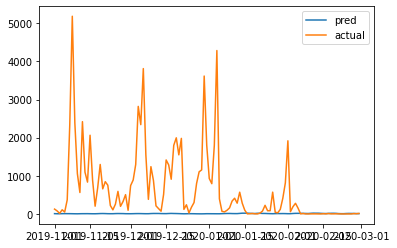

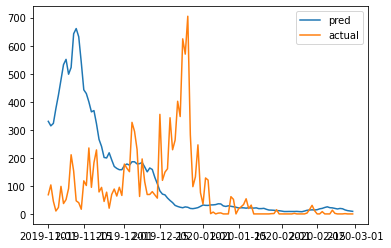

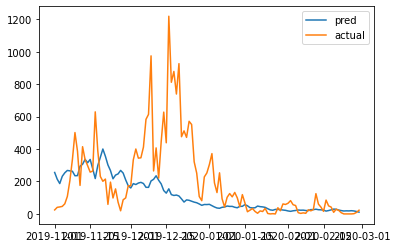

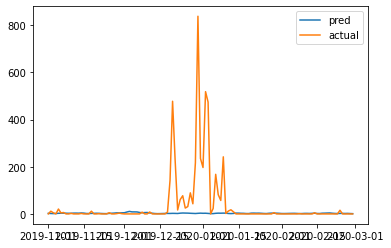

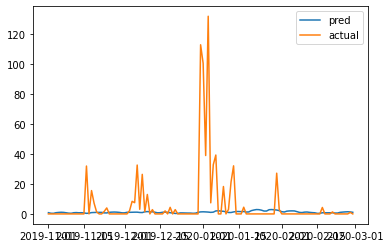

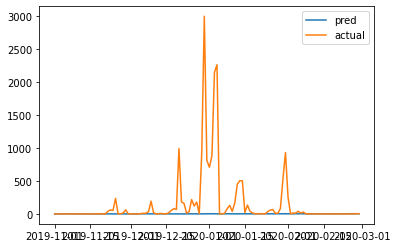

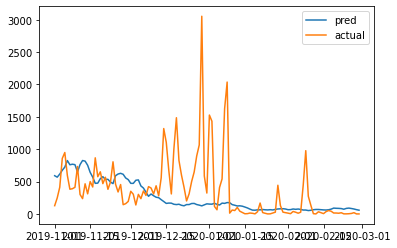

In [11]:
for i in regions:
    plt.plot(pred_df['Date'], pred_df[i], label= 'pred')
    plt.plot(test_df['Date'], test_df[i], label= 'actual')
    plt.legend()
    plt.show();

In [128]:
_results

{'dummy': {'mae': 30.77910896838424, 'mse': 25616.108672631646},
 'SARIMAX': {'mae': 30.83036581763828, 'mse': 25611.85265564216},
 'Prophet': {'mae': 33.51735382459243, 'mse': 24514.542351043412}}